In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import scipy.signal as sig

In [2]:
output_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\zeno_video_output\BW-0277\2024_01_18\000_raw_pose_data'
csv_file_name = 'FW_1_test_hip_heel_events.csv'
png_file_name = 'FW_1_test_hip_heel_events.png'

mp_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\zeno_video_output\BW-0277\2024_01_18\000_raw_pose_data\gait_vertical_FW_1_mediapipe.csv'
mp_world_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\zeno_video_output\BW-0277\2024_01_18\000_raw_pose_data\gait_vertical_FW_1_mediapipe_world.csv'
mari_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\zeno_video_output\BW-0277\2024_01_18\000_raw_pose_data\gait_vertical_FW_1_marigold.csv'
yolo_path = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\test_velocity_01302025\zeno_video_output\BW-0277\2024_01_18\000_raw_pose_data\gait_vertical_FW_1_yolo.csv'

In [3]:
# load datarames 
yolo_df = pd.read_csv(yolo_path, index_col = 0) 
mp_df = pd.read_csv(mp_path, index_col = 0)
mp_world_df = pd.read_csv(mp_world_path, index_col = 0)

In [4]:
def l_r_hip_heel_dist(df): 
    r_hip_df = df.loc[df['label'] == 'right_hip']
    r_hip_df.set_index('frame', inplace=True)

    l_hip_df = df.loc[df['label'] == 'left_hip']
    l_hip_df.set_index('frame', inplace=True)

    r_ankle_df = df.loc[df['label'] == 'right_ankle']
    r_ankle_df.set_index('frame', inplace=True)

    l_ankle_df = df.loc[df['label'] == 'left_ankle']
    l_ankle_df.set_index('frame', inplace=True)

    # try no smoothing - timing and order important and smoothing kind of shifts 
    # left dist  
    r_diff = abs(r_hip_df['Y'] - r_ankle_df['Y']) #.rolling(window=5, min_periods = 1).mean()

    # right dist 
    l_diff = abs(l_hip_df['Y'] - l_ankle_df['Y']) # .rolling(window=5, min_periods = 1).mean()

    # diff df 
    diff_df = pd.DataFrame({'frame': l_ankle_df.index, 
                            'r_diff' : r_diff, 
                            'l_diff' : l_diff}) 

    # find peaks 
    r_peaks_i, _ = sig.find_peaks(diff_df['r_diff'])
    l_peaks_i, _ = sig.find_peaks(diff_df['l_diff'])

    # peak frames 
    r_peaks_df = pd.DataFrame(data = {'frame' : diff_df.iloc[r_peaks_i].index,
                                     'peak_val' : diff_df.iloc[r_peaks_i]['r_diff']}) 
    
    l_peaks_df = pd.DataFrame(data = {'frame' : diff_df.iloc[l_peaks_i].index, 
                                      'peak_val' : diff_df.iloc[l_peaks_i]['l_diff']})
    
    

    return [diff_df, r_peaks_df, l_peaks_df]
                            

    


Text(0, 0.5, 'Hip to Ankle Diff')

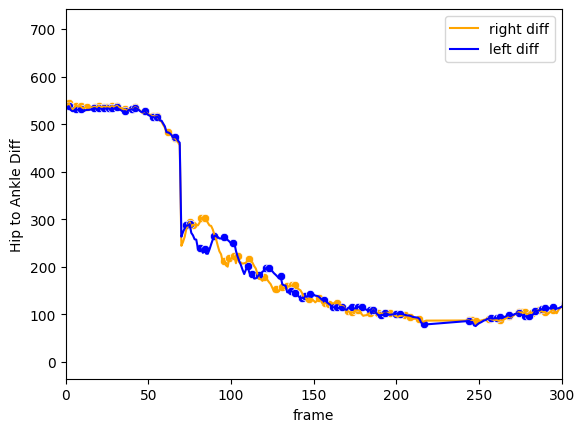

In [5]:
# yolo pixels 
yolo_diff_df, yolo_r_peaks_df, yolo_l_peaks_df = l_r_hip_heel_dist(yolo_df)  
sns.lineplot(x = 'frame', y = 'r_diff', data = yolo_diff_df, color = 'orange', label = 'right diff')
sns.lineplot(x = 'frame', y = 'l_diff', data = yolo_diff_df, color = 'blue', label = 'left diff')
sns.scatterplot(x = 'frame', y = 'peak_val', data = yolo_r_peaks_df, color = 'orange') 
sns.scatterplot(x = 'frame', y = 'peak_val', data = yolo_l_peaks_df, color = 'blue') 
plt.xlim([0, 300])
plt.ylabel('Hip to Ankle Diff')

Text(0, 0.5, 'Hip to Ankle Diff')

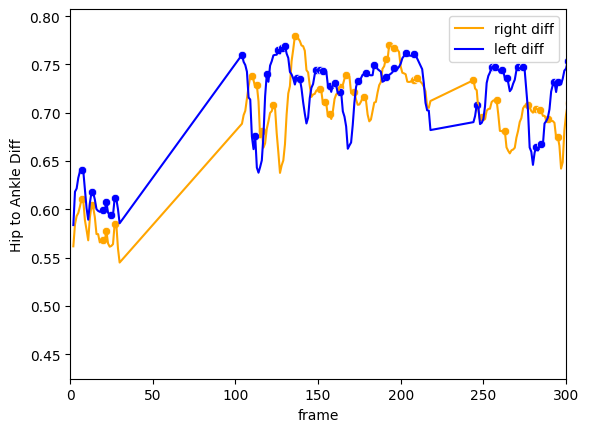

In [6]:
# mediapipe world diff between hip and heel = heel strike  
mp_diff_df, mp_r_peaks_df, mp_l_peaks_df = l_r_hip_heel_dist(mp_world_df) 

sns.lineplot(x = 'frame', y = 'r_diff', data = mp_diff_df, color = 'orange', label = 'right diff')
sns.lineplot(x = 'frame', y = 'l_diff', data = mp_diff_df, color = 'blue', label = 'left diff')
sns.scatterplot(x = 'frame', y = 'peak_val', data = mp_r_peaks_df, color = 'orange') 
sns.scatterplot(x = 'frame', y = 'peak_val', data = mp_l_peaks_df, color = 'blue') 
plt.xlim([0, 300])
plt.ylabel('Hip to Ankle Diff')

# peak diff = heel strike - heel is furthest from the hip

In [7]:
mp_world_df.head()

,X,Y,Z,vis,pres,frame,label
0,inf,inf,inf,inf,inf,0,NaN
0,inf,inf,inf,inf,inf,1,NaN
0,0.085708,-0.652374,-0.090506,0.989400,0.0,2,nose
1,0.062845,-0.673310,-0.129175,0.993705,0.0,2,left_eye_inner
2,0.062972,-0.673547,-0.128483,0.992893,0.0,2,left_eye


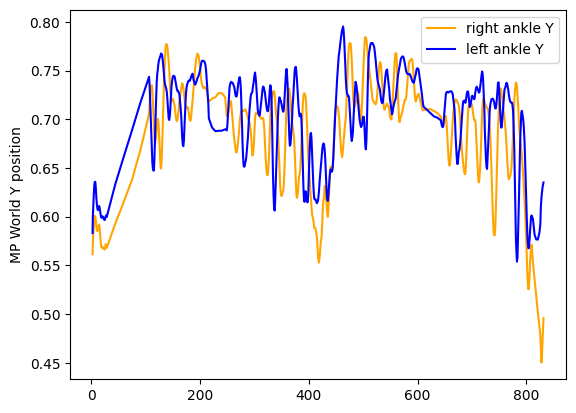

In [8]:
# plot mediapipe world r and l heel position 
plt.plot(mp_world_df.loc[mp_world_df['label'] == 'right_ankle']['frame'].rolling(window=5, min_periods = 1).mean(), 
         mp_world_df.loc[mp_world_df['label'] == 'right_ankle']['Y'].rolling(window=5, min_periods = 1).mean(), 
         color = 'orange',
         label = 'right ankle Y')

plt.plot(mp_world_df.loc[mp_world_df['label'] == 'left_ankle']['frame'].rolling(window=5, min_periods = 1).mean(), 
         mp_world_df.loc[mp_world_df['label'] == 'left_ankle']['Y'].rolling(window=5, min_periods = 1).mean(), 
         color = 'blue',
         label = 'left ankle Y')

plt.ylabel('MP World Y position')
plt.legend()

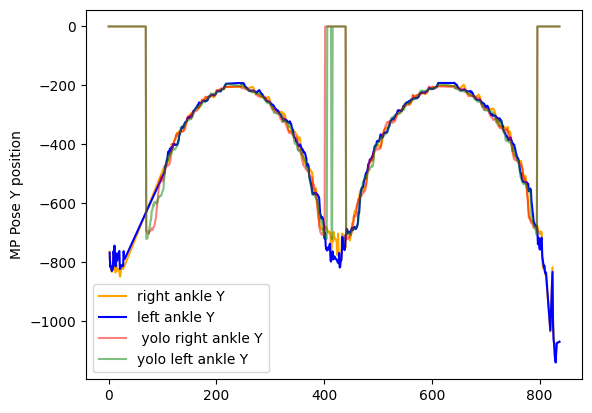

In [9]:
# mediapipe pose units - think ok to use? but idk if they are changing 

plt.plot(mp_df.loc[mp_df['label'] == 'right_ankle']['frame'], 
         -mp_df.loc[mp_df['label'] == 'right_ankle']['Y'], 
         color = 'orange',
         label = 'right ankle Y')

plt.plot(mp_df.loc[mp_df['label'] == 'left_ankle']['frame'], 
         -mp_df.loc[mp_df['label'] == 'left_ankle']['Y'], 
         color = 'blue',
         label = 'left ankle Y')

plt.plot(yolo_df.loc[yolo_df['label'] == 'right_ankle']['frame'], 
         -yolo_df.loc[yolo_df['label'] == 'right_ankle']['Y'], 
         color = 'red',
         alpha = 0.5,
         label = ' yolo right ankle Y')

plt.plot(yolo_df.loc[yolo_df['label'] == 'left_ankle']['frame'], 
         -yolo_df.loc[yolo_df['label'] == 'left_ankle']['Y'], 
         alpha = 0.5,
         color = 'green',
         label = 'yolo left ankle Y')


plt.ylabel('MP Pose Y position')
plt.legend()
#plt.xlim([150, 300])

In [10]:
# plot mediapipe r and l heel position 

In [11]:
# identify where ankle y positions cross - toe off? 
def id_cross_frame(df):

    # yolo where right and left Y position cross = toe off 
    r_ankle_df = df.loc[df['label'] == 'right_ankle']
    r_ankle_df.set_index('frame', inplace=True)

    l_ankle_df = df.loc[df['label'] == 'left_ankle']
    l_ankle_df.set_index('frame', inplace=True)

    ankle_y_df = pd.DataFrame(data = {'r_ankle_neg_y' : -r_ankle_df['Y'], 
                                      'l_ankle_neg_y' : -l_ankle_df['Y']} 
                             )
    ankle_y_df['r_l_neg_y_mean'] =  ankle_y_df[['r_ankle_neg_y', 
                                              'l_ankle_neg_y']].mean(axis=1)

    # Create a new column to identify whether col1 is greater than col2
    ankle_y_df['r_greater'] = ankle_y_df['r_ankle_neg_y'] > ankle_y_df['l_ankle_neg_y']

    # Find the places where the value of 'col1_greater' changes
    ankle_y_df['change'] = ankle_y_df['r_greater'].ne(ankle_y_df['r_greater'].shift())
    #print(ankle_y_df.head())

    # Get the frames where the change happens 
    y_cross_df = ankle_y_df.loc[ankle_y_df['change'] == True]

    return y_cross_df

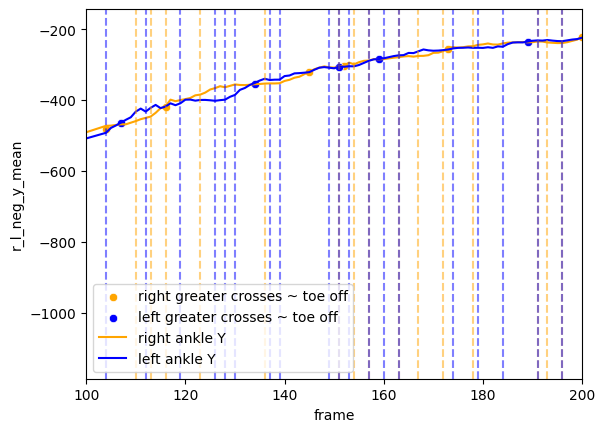

In [13]:
mp_y_cross_df = id_cross_frame(mp_df)



sns.scatterplot(x = 'frame', y = 'r_l_neg_y_mean',  
                data = mp_y_cross_df.loc[mp_y_cross_df['r_greater'] == True],
                color = 'orange',
                label = 'right greater crosses ~ toe off')

sns.scatterplot(x = 'frame', y = 'r_l_neg_y_mean',  
                data = mp_y_cross_df.loc[mp_y_cross_df['r_greater'] == False],
                color = 'blue',
                label = 'left greater crosses ~ toe off')

plt.plot(mp_df.loc[mp_df['label'] == 'right_ankle']['frame'], 
         -mp_df.loc[mp_df['label'] == 'right_ankle']['Y'], 
         color = 'orange',
         label = 'right ankle Y')

plt.plot(mp_df.loc[mp_df['label'] == 'left_ankle']['frame'], 
         -mp_df.loc[mp_df['label'] == 'left_ankle']['Y'], 
         color = 'blue',
         label = 'left ankle Y')

# plot peaks from mediapipe world 
for frame_r in mp_r_peaks_df['frame']: 
    plt.axvline(frame_r, color = 'orange', linestyle = '--', alpha = 0.5)

for frame_l in mp_l_peaks_df['frame']: 
    plt.axvline(frame_l, color = 'blue', linestyle = '--', alpha = 0.5)

plt.xlim([100, 200])
plt.legend()

In [16]:
mp_y_cross_df.head()

,r_ankle_neg_y,l_ankle_neg_y,r_l_neg_y_mean,r_greater,change
frame,,,,,
2,-763.693942,-766.818076,-765.256009,True,True
4,-811.737885,-811.398247,-811.568066,False,True
7,-815.093566,-826.556298,-820.824932,True,True
9,-766.747311,-762.203786,-764.475549,False,True
104,-472.795119,-492.476904,-482.636011,True,True


In [18]:
mp_r_peaks_df.head()

,frame,peak_val
frame,,
7,7,0.610953
13,13,0.604260
20,20,0.567825
22,22,0.577507
27,27,0.585198


In [19]:
mp_l_peaks_df.head()

,frame,peak_val
frame,,
7,7,0.610953
13,13,0.604260
20,20,0.567825
22,22,0.577507
27,27,0.585198


In [40]:
def id_gait_events_one_cycle(start_frame, all_toe_off_df, r_heel_strike_df, l_heel_strike_df, mp_df):

    # blank df for each event 
    gait_events_df = pd.DataFrame()

    # new df - only rows starting at start frame row 
    toe_off_start_df = all_toe_off_df.loc[all_toe_off_df.index >= start_frame]
    print(toe_off_start_df.head())
    
    # first toe off foot 1 
    foot1_to_1 = toe_off_start_df.index[0]
    print(foot1_to_1)
    foot_1_side = toe_off_start_df['r_greater'].iloc[0]
    print(foot_1_side)
    
    # second toe off foot 1 - next toe off with same foot 1 side 
    foot1_to_2_df = toe_off_start_df.loc[toe_off_start_df['r_greater'] == foot_1_side]
    print(foot1_to_2_df.head())

    print(foot1_to_2)

    # plot first to second toe off 
    sns.scatterplot(x = 'frame', y = 'r_l_neg_y_mean',  
                data = all_toe_off_df.loc[all_toe_off_df['r_greater'] == True],
                color = 'orange',
                label = 'right greater crosses ~ toe off')

    sns.scatterplot(x = 'frame', y = 'r_l_neg_y_mean',  
                data = all_toe_off_df.loc[all_toe_off_df['r_greater'] == False],
                color = 'blue',
                label = 'left greater crosses ~ toe off')

    plt.plot(mp_df.loc[mp_df['label'] == 'right_ankle']['frame'], 
             -mp_df.loc[mp_df['label'] == 'right_ankle']['Y'], 
             color = 'orange',
             label = 'right ankle Y')

    plt.plot(mp_df.loc[mp_df['label'] == 'left_ankle']['frame'], 
            -mp_df.loc[mp_df['label'] == 'left_ankle']['Y'], 
             color = 'blue',
             label = 'left ankle Y')
    plt.xlim([foot1_to_1, ])

    # is there a toe off of foot two between both foot 1 toe offs?
        # if no --> blank data frame --> don't calc 
        # if yes --> foot 2 first toe off



    

    

    
id_gait_events_one_cycle(start_frame = 2, 
                             all_toe_off_df = mp_y_cross_df, 
                             r_heel_strike_df = mp_r_peaks_df, 
                             l_heel_strike_df = mp_l_peaks_df, 
                            mp_df= mp_df)


KeyError: "None of ['frame'] are in the columns"

In [ ]:
for toe_off_frame_i, toe_off_frame in enumerate(mp_y_cross_df['frame']): 
    id_gait_events_one_cycle(start_frame = toe_off_frame, 
                             all_toe_off_df = mp_y_cross_df, 
                             r_heel_strike_df = mp_r_peaks_df, 
                             l_heel_strike_df = mp_l_peaks_df)

In [ ]:

def calculate_metrics_per_cycle()

In [15]:
# function - start at heel strike? or toe off? and id gait events 
# state estimator 
    # toe off to toe off --> find (first? max?) heel strike (max hip heel dist) between the two toe offs; max if multiple 



# left stats 
left_stats = []
right_stats = []

# loop start - loop through each frame of mp_y_cross_df (toe off) 

    # blank dataframe  - gait cycle (toe off 1, heel strike 1, toe off 2 etc) 

    # new - function fill in blank data frame with each gait cycle event  
         # if not able to

    # new function - if step above is not nan, calculate double single support, stance/swing, etc 
       

    # ifmp_y_cross_df r_greater == Tru append to righ tstats, append to lef tstats if false 

# mean/median 

,r_ankle_neg_y,l_ankle_neg_y,r_l_neg_y_mean,r_greater,change
frame,,,,,
2,-763.693942,-766.818076,-765.256009,True,True
4,-811.737885,-811.398247,-811.568066,False,True
7,-815.093566,-826.556298,-820.824932,True,True
9,-766.747311,-762.203786,-764.475549,False,True
104,-472.795119,-492.476904,-482.636011,True,True
